In [1]:
#Ref: Code from https://medium.com/analytics-vidhya/introduction-to-bert-f9aa4075cf4f used here
#Install following libraries before first run. For subsequent runs, you may comment these
# !pip install tensorflow_hub
# !pip install bert-for-tf2
# !pip install sentencepiece
#!pip install tensorflow-gpu

#Importing Required libraries
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from bert import bert_tokenization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle
#Tensorflow version
print("Tensorflow Version:", tf.__version__)
pd.options.mode.chained_assignment = None

Tensorflow Version: 2.9.1


In [2]:
#Loading Data
df = pd.read_csv('./data_with_mapped_phrases.csv') 
#This has this will have 5 columns 1) annotation, 2) student_note , 3) teacher_feedback 4) phrases  & 5) score , 
#score column is for reference and it is not used for BERT or T5 trainining
# teacher_feedback column is used for T5 model traiining while phrases column is used for BERT model
#print ( f'Data Shape: {df.shape} ') #Number of rows and column in data-frame


In [3]:
#Data cleaning
df = df[df['student_note'].notnull()]
print ( f'Data Shape: {df.shape} ') 
df = df[df['annotation'].notnull()]
print ( f'Data Shape: {df.shape} ') 
df = df[df['teacher_feedback'].notnull()]
print ( f'Data Shape: {df.shape} ') 
df = df[df.student_note != 'note' ]
print ( f'Data Shape: {df.shape} ')

df['annotation'] = df['annotation'].str.strip()
df['student_note'] = df['student_note'].str.strip()

df = df [df['annotation'].str.len() > 3]
print ( f'Data Shape: {df.shape} ')
df = df [df['student_note'].str.len() > 3]
print ( f'Data Shape: {df.shape} ')

df = df.drop_duplicates(subset=['annotation', 'student_note'])
print ( f'Data Shape: {df.shape} ') 
print ( f'Data Shape: {df.shape} ')

Data Shape: (66317, 9) 
Data Shape: (59609, 9) 
Data Shape: (59609, 9) 
Data Shape: (59602, 9) 
Data Shape: (50981, 9) 
Data Shape: (50689, 9) 
Data Shape: (50406, 9) 
Data Shape: (50406, 9) 


In [ ]:
#Looking into data, cleared output so as not to expose data
display(df.sample(2)) #Sample rows of dataframe

df['phrases'].value_counts(normalize=True) 

In [5]:
# Splitting data into test and training. This is used for training/testing BERT as well as T5 model
df_train, df_test = train_test_split( df , test_size=0.2, random_state=42)

print( f'Training Data Shape: {df_train.shape}  ,  Test Data Shape:  {df_test.shape}') # Rows/Cols in train/test data

df_train.to_csv ('train_data.csv' , index=False)
df_test.to_csv ('test_data.csv' , index=False)

Training Data Shape: (40324, 9)  ,  Test Data Shape:  (10082, 9)


In [14]:
#Loading BERT Standard model (Pretrained Model on Wikipedia and Book Corpus)
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True, name = 'keras_bert_layer' )

#Getting vocab file from bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy() 

do_lower_case = True  # For uncased model it will True 

#Defining tokenizer object which will be used to tokenize text before feeding to bert
tokenizer_for_bert = bert_tokenization.FullTokenizer(vocab_file, do_lower_case) #Tokenizer to tokenize input text

print ( '\nLength of vocab in our tokenizer : ' , len(tokenizer_for_bert.vocab) ) #BERT vocab has around 30K words


Length of vocab in our tokenizer :  30522


In [15]:
#Function to encode text in format to feed to BERT

def encode_text_for_bert2 (texts, tokenizer_for_bert, max_len=512):
    ''' This function is to encode data for inputting into BERT model
    Parameters:
    texts - List of texts to encode
    tokenizer_for_bert - Tokenizer to be used to convert text into tokens
    max_len - Maximum length of text. It can have maximum value as 512
    Return: Tupple of 3 numpy arrays 
    1) Token Ids padded with 0s to make length as max_len.  
    2) Array where we have 1 for actual tokens and 0 for padding tokens
    3) Array of 0s to indicate that token belongs to 1st sentence (chunk of text). There is no 2nd sentence here.
    '''
    all_token_ids = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        [text1, text2] = text.split(' Student Note: ')[:2]
        text1 = text1.strip()
        text2 = text2.strip()
        
        tokens = tokenizer_for_bert.tokenize(text1) + ["[SEP]"] +  tokenizer_for_bert.tokenize(text2)
            
        tokens = tokens[:max_len-3] # Truncating number of tokens to max_len -3, Reduced extra 3 to add special tokens
        
        input_sequence = ["[CLS]"] + tokens + ["[SEP]"]  # [CLS] and [SEP] are special tokens to be added into input text
        
        pad_len = max_len - len(input_sequence) # Spaces to fill with 0s to make each sequence equal to max_len
        
        token_ids = tokenizer_for_bert.convert_tokens_to_ids(input_sequence)   #Converting tokens to token ids 
       
        token_ids += [0] * pad_len  #Padding token ids with 0s
        
        pad_masks = [1] * len(input_sequence) + [0] * pad_len # 1 where we have sentence tokens and 0 otherwise
        
        segment_ids = [0] * max_len # Segment ids are all 0 to indicate it is part of sentence 1. There is no sentence 2 here
        
        all_token_ids.append(token_ids)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_token_ids), np.array(all_masks), np.array(all_segments)


#Optional Step: This is just to understand input/output of function encode_text_for_bert
test_text =  "Annotation: Welcome to  CommonLit project, Student Note: Yes I agree "

print ("Test text after encoding: " ,encode_text_for_bert2 ( [test_text], tokenizer_for_bert, 12) ) # Pl Note id 101 is for token [CLS] and 102 for token [SEP]


Test text after encoding:  (array([[  101,  5754, 17287,  3508,  1024,  6160,  2000,  2691, 15909,
         2622,   102,     0]]), array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))


In [16]:
#Creating BERT  Model 
def bert_model_creation (bert_layer, max_len=512, model_type = 'Classification', num_classes = 2):
    '''This function is to create BERT model for Classification or Regession Task
    Parameters:
    model_type = 'Classification' for classification task or 'Regression' for regression task. 
    num_classes = Number of classes in classification task. Value of 2 means binary classification. More than 2 for multiclass classification.
                  For regression, num_classes parameter is ignored.
    Return: Deep Learning Model
    Important: You may add additional dense layers in place holder provided as "***PLACEHOLDFER FOR ADDITIONAL LAYERS****"
    '''   
    #Input to bert layer
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    #Output from bert layer
    bert_layer_out = bert_layer([input_word_ids, input_mask, segment_ids]) # Python list of 2 tensors with shape (batch_size, 768) and (batch_size, max_len, 768)
    
    #Extrating Embedding for CLS token comming out of bert layer. Note CLS is the first token
    cls_out = bert_layer_out[1][:,0,:] # Getting hidden-state of 1st tokens from second tensor in bert_layer_out, Tensor shape - (batch size, 768) 
    cls_out, _ = bert_layer_out  #Taking pooled output
    
    
    #***PLACEHOLDFER FOR ADDITIONAL LAYERS****. 
    #Add more layers here if you want. See example below
    cls_out = Dropout(.50) (cls_out)
    cls_out = Dense(500, activation='relu')(cls_out) 
    
    
    
    #Defines last layer depending on model type and  number of classes. Activation function is used depending on model_type and num_classes
    if model_type == 'Classification' :
        if num_classes == 2 :
            out = Dense(1, activation='sigmoid')(cls_out)     # ** For Binary classification, use sigmoid activation
        else:    
            out = Dense(num_classes, activation='softmax')(cls_out) # For Multi Class classification, use softmax activation
    else:
        out = Dense(1, activation='linear')(cls_out)     # For regression, use linear activation
    
    #Model creation using inputs and output
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out, name='deeplearning_bert__model')
    
    
    
    learning_rate = 2e-6 # modify learning rate,as needed
    
    #Compiles Model depending on model type and number of classes. Loss function as well as metrics is used accordingly
    if model_type == 'Classification' :
        if num_classes == 2 :
            model.compile(Adam(learning_rate= learning_rate), loss='binary_crossentropy', metrics=['acc']) # ** For Binary classification
        else:
            model.compile(Adam(learning_rate= learning_rate), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy']) # For Multi Class classification 
    else:
        model.compile(Adam(learning_rate= learning_rate), loss='mse', metrics=['mse']) # For Regression
        
    return model

In [17]:
max_len = 256 #Max length of text input to model. It can go up to 512. Keeping it small to run it faster

In [18]:
#Building Classification Model
#modify values of model_type and num_classes as per need
model = bert_model_creation(bert_layer, max_len=max_len, model_type = 'Classification', num_classes = 21) #binary classification as num_classes = 2

#Model Summary. Pl note, there are ~109 Million parameters as it is BERT standard model
model.summary() 

Model: "deeplearning_bert__model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 keras_bert_layer (KerasLayer)  [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 256, 768)]                'input_ma

In [19]:
#Encoding Training Data for BERT.  If you want  preprocessing/cleaning of input text, it should be done before this step
train_input = encode_text_for_bert2((df_train['annotation']+ ' Student Note: ' + df_train['student_note']).values, tokenizer_for_bert, max_len= max_len)

#Output variable  for multi-class classification 
le = preprocessing.LabelEncoder()
y_train = df_train['phrases'].values 
y_train = le.fit_transform(y_train)

filehandler = open("le.obj","wb")
pickle.dump(le,filehandler)
filehandler.close()

In [20]:
#Optional step: Checking accuracy on train data before fine-tuning so that we can see improvement by fine tuning
# predictions = model.predict(train_input)
# accuracy_score (y_train,  np.argmax(predictions, axis = 1))

In [21]:
#Model Training (Fine-tuning for  classification) 
epochs = 5    #Modify as neded
batch_size = 32  #Modify as needed
train_history = model.fit(train_input, y_train ,  validation_split=0.10 , epochs= epochs,batch_size= batch_size, verbose=1)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1135/1135 [==============================] - ETA: 0s - loss: 2.6518 - sparse_categorical_accuracy: 0.2309WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f84283baa70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1135/1135 [==============================] - 1093s 948ms/step - loss: 2.6518 - sparse_categorical_accuracy: 0.2309 - val_loss: 2.4947 - val_sparse_categorical_accuracy: 0.2680
Epoch 2/5
1135/1135 [==============================] - 1074s 947ms/step - loss: 2.4978 - sparse_categorical_accuracy: 0.2566 - val_loss: 2.4342 - val_sparse_categorical_accuracy: 0.2700
Epoch 3/5
1135/1135 [==============================] - 1073s 946ms/step - loss: 2.4305 - sparse_categorical_accuracy: 0.2661 - val_loss: 2.3903 - val_sparse_categorical_accuracy: 0.2757
Epoch 4/5
1135/1135 [==============================] - 1075s 947ms/step - loss: 2.3590 - sparse_categorical_accuracy: 0.2820 - val_loss: 2.35

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


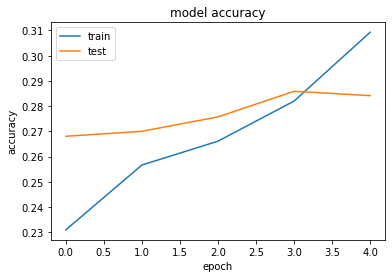

In [22]:
print(train_history.history.keys())
history = train_history.history
# summarize history for accuracy
plt.plot(history['sparse_categorical_accuracy'])
plt.plot(history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [23]:
#Checking accuracy on train 
# predictions = model.predict(train_input)
# accuracy_score (y_train,  np.argmax(predictions, axis = 1))

In [24]:
#Encoding test data into BERT Format. If you have  preprocessing/cleaning of input text, it should be done before this step
test_input = encode_text_for_bert2((df_test['annotation'] + ' Student Note: ' + df_test['student_note']).values, tokenizer_for_bert, max_len= max_len)
y_test = le.transform(df_test['phrases'].values )

In [35]:
#Checking accuracy on test data. You may be able to improve it by taking bigger length of text, more epochs or by adding more dense layers into the model
predictions = model.predict(test_input)
accuracy_score (y_test,  np.argmax(predictions, axis = 1))

316/316 [==============================] - 100s 318ms/step


0.29111287442967665

In [37]:
#getting top 3 predictions
top3 = predictions.argsort(axis = 1)[:, -3:]
pred_top = le.inverse_transform(top3[:, -1])
pred_top_2nd = le.inverse_transform(top3[:, -2])
pred_top_3rd = le.inverse_transform(top3[:, -3])

In [38]:
#Adding top 3 predictions to dataframe
df_test['inferred_phrase_top'] = pred_top.tolist()
df_test['inferred_phrase_top_2nd'] = pred_top_2nd.tolist()
df_test['inferred_phrase_top_3rd'] = pred_top_3rd.tolist()

In [39]:
df_test.to_csv('test_data.csv', index=False)

In [ ]:
#Saving fine-tuned(trained) model to disk
model.save('./bertmodel_feedback_prediction')


In [41]:
# Loading model for inference
model = load_model('./bertmodel_feedback_prediction')

#Loading Label encoder
file = open('le.obj', 'rb')
le = pickle.load(file)
file.close()

In [43]:
annotation = "banks had very few rules about loaning out money." 
student_note = "Seems like the banks should have done something sooner"
prediction = model.predict (  encode_text_for_bert2 ( [annotation + ' Student Note: ' + student_note] , tokenizer_for_bert, max_len=max_len) ) 
top3 = prediction.argsort(axis = 1)[:, -3:]
pred_top = le.inverse_transform(top3[:, -1])
pred_top_2nd = le.inverse_transform(top3[:, -2])
pred_top_3rd = le.inverse_transform(top3[:, -3])

print ('Annotaion:', annotation , '\nStudent Note:', student_note)
print(f'\nInferred Feedback Phrases:  1){pred_top[0]}  2){pred_top_2nd[0]}  3){pred_top_3rd[0]}')

1/1 [==============================] - 0s 34ms/step
Annotaion: banks had very few rules about loaning out money. 
Student Note: Seems like the banks should have done something sooner

Inferred Feedback Phrases:  1)Good job!  2)Why?  3)Explain why this is important.


In [44]:
annotation = "night was dark. The wind blew." 
student_note = "there are 13 stanzas "

prediction = model.predict (  encode_text_for_bert2 ( [annotation + ' Student Note: ' + student_note] , tokenizer_for_bert, max_len=max_len) ) 
top3 = prediction.argsort(axis = 1)[:, -3:]
pred_top = le.inverse_transform(top3[:, -1])
pred_top_2nd = le.inverse_transform(top3[:, -2])
pred_top_3rd = le.inverse_transform(top3[:, -3])

print ('Annotaion:', annotation , '\nStudent Note:', student_note)
print(f'\nInferred Feedback Phrases:  1){pred_top[0]}  2){pred_top_2nd[0]}  3){pred_top_3rd[0]}')

1/1 [==============================] - 0s 34ms/step
Annotaion: night was dark. The wind blew. 
Student Note: there are 13 stanzas 

Inferred Feedback Phrases:  1)Good job!  2)Why?  3)Add more detail.


In [33]:
annotation = "He was heart-broken." 
student_note = "She is so caught up in trying to fit in she never realizes how she is hurting her husband."

prediction = model.predict (  encode_text_for_bert2 ( [annotation + ' Student Note: ' + student_note] , tokenizer_for_bert, max_len=max_len) ) 
top3 = prediction.argsort(axis = 1)[:, -3:]
pred_top = le.inverse_transform(top3[:, -1])
pred_top_2nd = le.inverse_transform(top3[:, -2])
pred_top_3rd = le.inverse_transform(top3[:, -3])

print ('Annotaion:', annotation , '\nStudent Note:', student_note)
#print('\nInferred Feedback Phrase: ', le.inverse_transform( np.argmax(prediction).reshape(-1, 1) )[0] )
print(f'\nInferred Feedback Phrases:  1){pred_top[0]}  2){pred_top_2nd[0]}  3){pred_top_3rd[0]}')

1/1 [==============================] - 0s 34ms/step
Annotaion: He was heart-broken. 
Student Note: She is so caught up in trying to fit in she never realizes how she is hurting her husband.

Inferred Feedback Phrases:  1)Add more detail.  2)Explain why this is important.  3)Why?
